# Imports

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
%matplotlib inline

# Prepare the Dataset

In [31]:
dataset = MNIST(root="data/", train=True, download=True, transform=ToTensor())
test_ds = MNIST(root="data/", train=False, transform=ToTensor())

train_ds, val_ds = random_split(dataset, (50_000, 10_000))

len(train_ds), len(val_ds), len(test_ds)

(50000, 10000, 10000)

In [32]:
BATCH_SIZE = 128

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE*2, num_workers=2, pin_memory=True)

test_dl = DataLoader(test_ds, BATCH_SIZE*2, num_workers=2, pin_memory=True)

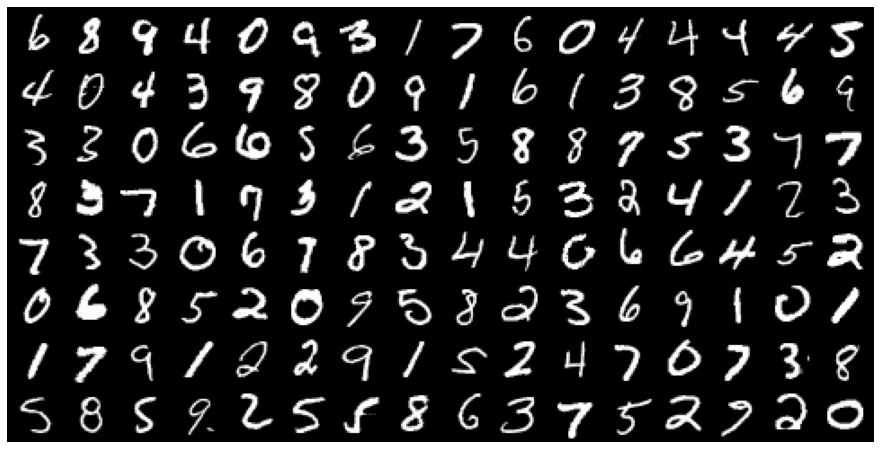

In [33]:
for images, _ in train_dl:
  plt.figure(figsize=(16, 8))
  plt.axis("off")
  plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
  break

## Device and DeviceDataloader

In [34]:
def get_device():
  """Pick GPU if GPU is available, else pick CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

In [35]:
device = get_device()
device

device(type='cuda')

In [36]:
def to_device(data, device):
  """Move Tensors to specified device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [37]:
class DeviceDataloader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for batch in self.dl:
      yield to_device(batch, self.device)

  def __len__(self):
    """Returns the number of batches in the dataloader"""
    return len(self.dl)

In [38]:
train_loader = DeviceDataloader(train_dl, device)
val_loader = DeviceDataloader(val_dl, device)
test_loader = DeviceDataloader(test_dl, device)

# Model

In [39]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [40]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss": loss, "val_acc": acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], Val_Loss: {:.4f}, Val_Acc: {:.4f}".format(epoch, result["val_loss"], result["val_acc"]))

In [41]:
class MNISTModel(ImageClassificationBase):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, output_size)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.layer1(xb)
    out = F.relu(out)
    out = self.layer2(out)
    return out

In [42]:
input_size = 28*28
hidden_size = 32
output_size = 10

model = MNISTModel(input_size, hidden_size, output_size)
model = to_device(model, device)

In [43]:
model

MNISTModel(
  (layer1): Linear(in_features=784, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=10, bias=True)
)

# Training

In [44]:
def evaluate(model, dataloader):
  outputs = [model.validation_step(batch) for batch in dataloader]
  return model.validation_epoch_end(outputs)

In [45]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = []

  for epoch in range(epochs):
    # Training Step
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation Step
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [46]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.09589843451976776, 'val_loss': 2.3102550506591797}]

An initial accuarcy of approx. 10%

In [47]:
history += fit(5, 0.5, model, train_loader, val_loader)
history[-1]

Epoch [0], Val_Loss: 0.2764, Val_Acc: 0.9207
Epoch [1], Val_Loss: 0.2109, Val_Acc: 0.9420
Epoch [2], Val_Loss: 0.1712, Val_Acc: 0.9526
Epoch [3], Val_Loss: 0.1722, Val_Acc: 0.9508
Epoch [4], Val_Loss: 0.1410, Val_Acc: 0.9591


{'val_acc': 0.9590820074081421, 'val_loss': 0.14102259278297424}

In [48]:
history += fit(5, 0.1, model, train_loader, val_loader)
history[-1]

Epoch [0], Val_Loss: 0.1302, Val_Acc: 0.9632
Epoch [1], Val_Loss: 0.1292, Val_Acc: 0.9629
Epoch [2], Val_Loss: 0.1275, Val_Acc: 0.9637
Epoch [3], Val_Loss: 0.1276, Val_Acc: 0.9641
Epoch [4], Val_Loss: 0.1251, Val_Acc: 0.9646


{'val_acc': 0.964550793170929, 'val_loss': 0.12512747943401337}

# Visualization and Model Analysis

Text(0.5, 1.0, 'Model Loss vs Number of Epochs')

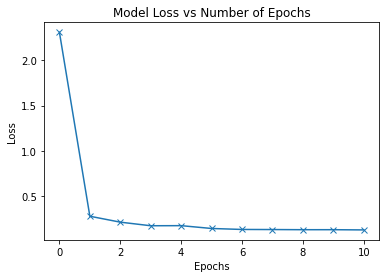

In [49]:
losses = [x["val_loss"] for x in history]
plt.plot(losses, "-x")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Model Loss vs Number of Epochs")

Text(0.5, 1.0, 'Model Accuracy vs Number of Epochs')

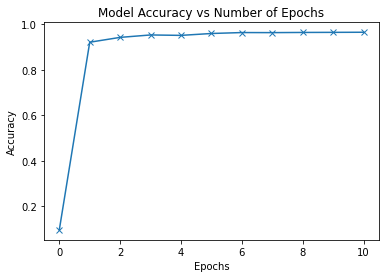

In [50]:
losses = [x["val_acc"] for x in history]
plt.plot(losses, "-x")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Model Accuracy vs Number of Epochs")

# Testing

In [51]:
def predict(image, model):
  xb = image.unsqueeze(0)
  xb = to_device(xb, device)
  out = model(xb)
  _, preds = torch.max(out, dim=1)
  return preds[0].item()

Label: 7 Predicted: 7


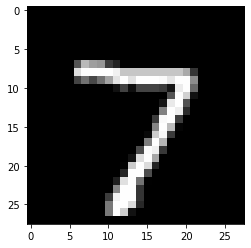

In [52]:
image, label = test_ds[0]
plt.imshow(image[0], cmap="gray")
print("Label: {} Predicted: {}".format(label, predict(image, model)))

Label: 9 Predicted: 9


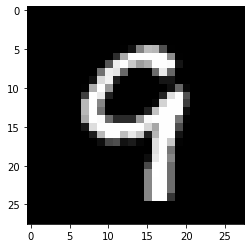

In [53]:
image, label = test_ds[150]
plt.imshow(image[0], cmap="gray")
print("Label: {} Predicted: {}".format(label, predict(image, model)))

Label: 7 Predicted: 7


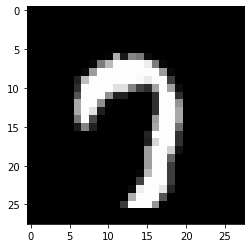

In [54]:
image, label = test_ds[220]
plt.imshow(image[0], cmap="gray")
print("Label: {} Predicted: {}".format(label, predict(image, model)))

In [55]:
test_result = evaluate(model, test_loader)
test_result

{'val_acc': 0.9708007574081421, 'val_loss': 0.10117577761411667}

Similar accuracies were obtained in the test and validation set. This shows that our validation set is good i.e. it has a good distribution, it can be representatiove of the real world.

# Saving the Model

In [56]:
torch.save(model.state_dict(), "MNIST_Feedforward.pth")

In [57]:
model2 = MNISTModel(input_size, hidden_size, output_size)
model2 = to_device(model2, device)
model2.load_state_dict(torch.load("MNIST_Feedforward.pth"))

<All keys matched successfully>

In [58]:
evaluate(model2, test_loader)

{'val_acc': 0.9708007574081421, 'val_loss': 0.10117577761411667}